Train 16-split models from E30 in isolation, without any pretraining. The accuracy achieved is assumed to be the maximum possible with these architectures.

In [20]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, nrows, ncols):
    ndata = np.zeros((len(data), nrows, ncols, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(ncols-width)
        y = np.random.randint(nrows-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
io_shape = (56,56,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16 * 4 # since we have 4x4-splits we need 4 times the latent space for a fair comparison.

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_reco = embed_and_translate(x_train, 56, 56)
x_train_split = np.array([utils.split(x, size, size) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_reco = embed_and_translate(x_test, 56, 56)
x_test_split = np.array([utils.split(x, size, size) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

1. Sigmoid latent space activation: ~91% accuracy

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.classifier = self._create_classifier(latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.classify(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
        ])

Epoch 1/40
1875/1875 [==============================] - 7s 4ms/step - loss: 1.8434 - acc: 0.2983 - val_loss: 1.5807 - val_acc: 0.4072
Epoch 2/40
1875/1875 [==============================] - 7s 3ms/step - loss: 1.3651 - acc: 0.5017 - val_loss: 1.1448 - val_acc: 0.5866
Epoch 3/40
1875/1875 [==============================] - 7s 4ms/step - loss: 1.0110 - acc: 0.6425 - val_loss: 0.8751 - val_acc: 0.6992
Epoch 4/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.8233 - acc: 0.7192 - val_loss: 0.7459 - val_acc: 0.7488
Epoch 5/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7129 - acc: 0.7624 - val_loss: 0.6650 - val_acc: 0.7821
Epoch 6/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6259 - acc: 0.7917 - val_loss: 0.6488 - val_acc: 0.7960
Epoch 7/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5592 - acc: 0.8186 - val_loss: 0.5279 - val_acc: 0.8325
Epoch 8/40
1875/1875 [==============================] - 7s 3ms

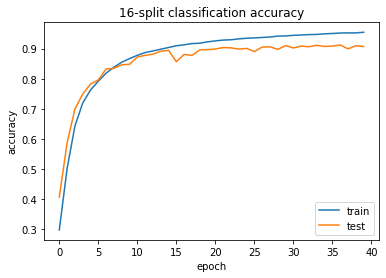

In [3]:
model = MultiSplit(n_splits, latent_dim, io_shape)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=40, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('16-split classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

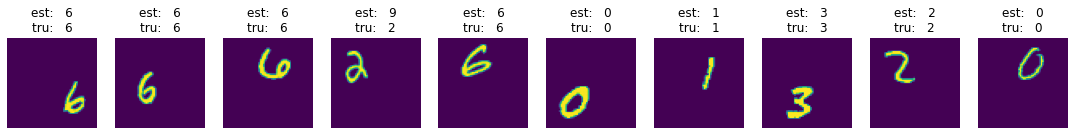

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random

n = 10
ints = [random.randint(0, len(x_test_split)) for _ in range(n)]
x_inputs = np.array([x_test_split[i] for i in ints], dtype='float32')
y_truths = [y_test[i] for i in ints]
x_truths = [x_test_augmented[i] for i in ints]

z = model.encode(x_inputs, training=False)
y = model.classify(z, training=False)
plt.figure(figsize=(19, 6))
for i in range(n):
    
    plt.subplot(1,n,i+1)
    plt.axis('off')
    plt.title("est: {:3.0f}\ntru: {:3.0f}".format(np.argmax(y[i]), np.argmax(y_truths[i])))
    plt.imshow(x_truths[i].reshape(56,56))

2. Regularized latent space + low initial weights. ~89% accuracy, plus latent space weights must be initialized to larger values.

In [21]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.classifier = self._create_classifier(latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_pred = self.classify(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.001)),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.001)),
            Flatten(),
#             Dense(units=latent_dim, kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.1), kernel_initializer=keras.initializers.RandomNormal(stddev=0.001))
            Dense(units=latent_dim, kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.1))  #!! Latent space weights must be initilized to larger values, otherwise classification does not work.
        ], name='encoder')
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
        ])

Epoch 1/40
1875/1875 [==============================] - 7s 4ms/step - loss: 1.6288 - acc: 0.4114 - val_loss: 1.1237 - val_acc: 0.6174
Epoch 2/40
1875/1875 [==============================] - 7s 4ms/step - loss: 1.0019 - acc: 0.6563 - val_loss: 0.8776 - val_acc: 0.7049
Epoch 3/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7852 - acc: 0.7324 - val_loss: 0.6946 - val_acc: 0.7708
Epoch 4/40
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6538 - acc: 0.7802 - val_loss: 0.6217 - val_acc: 0.7932
Epoch 5/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5841 - acc: 0.8048 - val_loss: 0.5782 - val_acc: 0.8089
Epoch 6/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5409 - acc: 0.8189 - val_loss: 0.5517 - val_acc: 0.8203
Epoch 7/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5060 - acc: 0.8304 - val_loss: 0.5431 - val_acc: 0.8229
Epoch 8/40
1875/1875 [==============================] - 7s 4ms

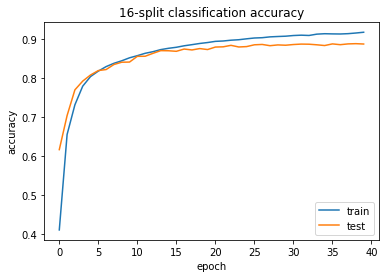

In [22]:
model = MultiSplit(n_splits, latent_dim, io_shape)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=40, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('16-split classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

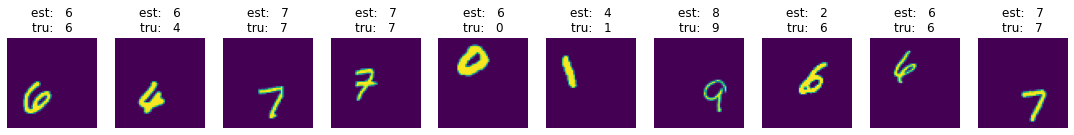

In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random

n = 10
ints = [random.randint(0, len(x_test_split)) for _ in range(n)]
x_inputs = np.array([x_test_split[i] for i in ints], dtype='float32')
y_truths = [y_test[i] for i in ints]
x_truths = [x_test_augmented[i] for i in ints]

z = model.encode(x_inputs, training=False)
y = model.classify(z, training=False)
plt.figure(figsize=(19, 6))
for i in range(n):
    
    plt.subplot(1,n,i+1)
    plt.axis('off')
    plt.title("est: {:3.0f}\ntru: {:3.0f}".format(np.argmax(y[i]), np.argmax(y_truths[i])))
    plt.imshow(x_truths[i].reshape(56,56))